<a href="https://colab.research.google.com/github/nivedhakannan-77/Brain_Stock_Detection./blob/main/Brain_Stroke_Detection(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [99]:
import os
import cv2
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Dataset Load and Spliting

In [100]:
data_dir = '/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')
validation_dir = os.path.join(data_dir, 'Validation')
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [101]:
import zipfile
import os

zip_path = "/content/archive(4).zip"
extract_path = "/content/brain_data"

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check what was extracted
print("Extracted folders/files:", os.listdir(extract_path))


Extracted folders/files: ['Brain_Stroke_CT-SCAN_image']


In [102]:
base_path = "/content/brain_data/Brain_Stroke_CT-SCAN_image"
train_dir = os.path.join(base_path, "Train")
validation_dir = os.path.join(base_path, "Validation")
test_dir = os.path.join(base_path, "Test")


In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 256, 256

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)


Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


# Pre-processing

In [104]:
# Image dimensions
img_width, img_height = 256, 256

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)


Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.


# Create BSP Model Architecture

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# Step 2: Model Architecture (Corrected)
model = Sequential()

# Add Input Layer first (fixes the warning)
model.add(Input(shape=(img_width, img_height, 3)))

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     7,372,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,466,177 (28.48 MB)

 Trainable params: 7,466,177 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

# Train and Test Model

In [106]:
import warnings
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call `super().__init__")

# Step 3: Model Training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

# Step 4: Model Evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

loss, accuracy = model.evaluate(test_generator)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.5636 - loss: 0.7640 - val_accuracy: 0.7532 - val_loss: 0.4806
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.8289 - loss: 0.3745 - val_accuracy: 0.9362 - val_loss: 0.1901
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9425 - loss: 0.1511 - val_accuracy: 0.9830 - val_loss: 0.0810
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9802 - loss: 0.0582 - val_accuracy: 0.9830 - val_loss: 0.0612
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9935 - loss: 0.0217 - val_accuracy: 0.9702 - val_loss: 0.0697
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9880 - loss: 0.0267 - val_accuracy: 0.9745 - val_loss: 0.0934
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9979 - loss: 0.0079 - val_accuracy: 0.9830 - val_loss: 0.0417
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9946 - loss: 0.0141 - val_accuracy: 0.9404 - v

In [78]:
model.save("brain_stroke_model.keras")
model = tf.keras.models.load_model("brain_stroke_model.keras")


# Accuracy And Loss Curve

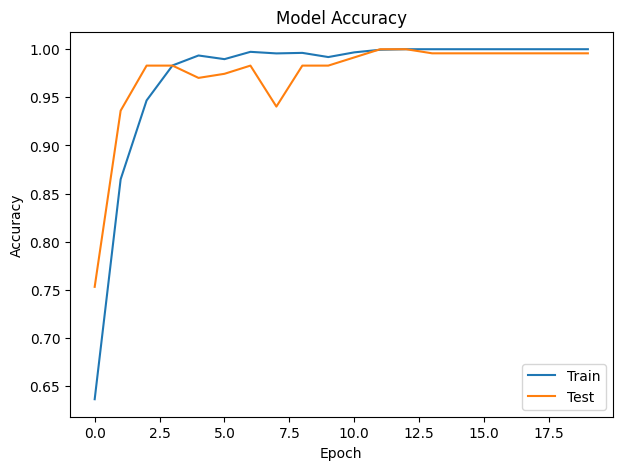

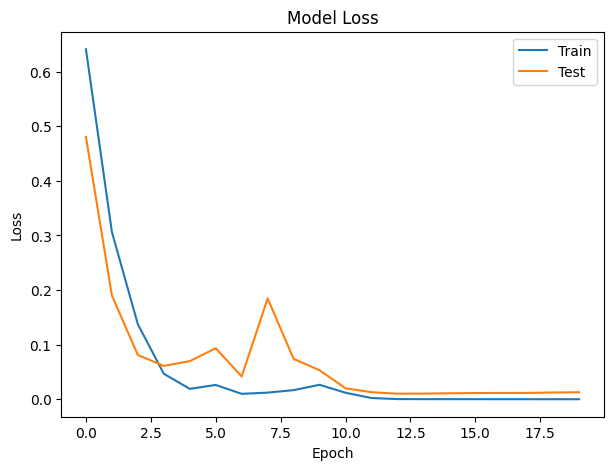

In [107]:

# Plot accuracy versus epoch
beingsaved = plt.figure(figsize=(7, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')
beingsaved.savefig('Accuracy.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Plot loss versus epoch
beingsaved = plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
beingsaved.savefig('Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Evulation Model

Found 437 images belonging to 2 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       307
           1       0.90      0.99      0.95       130

    accuracy                           0.97       437
   macro avg       0.95      0.97      0.96       437
weighted avg       0.97      0.97      0.97       437


------------------------------------------------------

Accuracy: 0.965675057208238
Precision: 0.9020979020979021
Recall: 0.9923076923076923
F1 Score: 0.945054945054945

------------------------------------------------------




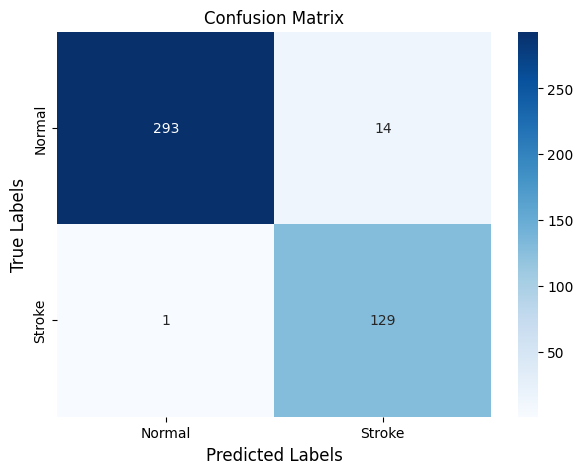

In [108]:
# Step 4: Model Evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
accuracy=accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred))
print('\n------------------------------------------------------\n')

print('Accuracy:',accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

print('\n------------------------------------------------------\n\n')
# Plot confusion matrix
label_names = ['Normal', 'Stroke']
beingsaved = plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xticks(np.arange(len(label_names)) + 0.5, label_names)
plt.yticks(np.arange(len(label_names)) + 0.5, label_names)
plt.xlabel('Predicted Labels',fontsize=12)
plt.ylabel('True Labels',fontsize=12)
plt.title('Confusion Matrix')
beingsaved.savefig('Stroke_Confusion_Matrix.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

In [109]:
for layer in model.layers:
    print(layer.name)

conv2d_21
max_pooling2d_21
conv2d_22
max_pooling2d_22
conv2d_23
max_pooling2d_23
flatten_7
dense_14
dense_15


In [110]:
# Dummy input to build the model (e.g. shape [1, 256, 256, 3])
dummy_input = tf.random.normal((1, 256, 256, 3))
_ = model(dummy_input)  # This "calls" the model


In [111]:
_ = model.predict(np.zeros((1, img_width, img_height, 3)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [112]:
for layer in model.layers:
    print(layer.name)


conv2d_21
max_pooling2d_21
conv2d_22
max_pooling2d_22
conv2d_23
max_pooling2d_23
flatten_7
dense_14
dense_15


# Detection Stroke using Grad Cam

In [113]:
def Affected_Area(img_path):

    image = cv2.imread(img_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply image processing operations (e.g., thresholding, morphological operations) for stroke detection
    _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a list to store the bounding boxes
    bounding_boxes = []

    # Draw bounding boxes around the contours
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return image



In [114]:
target_class_index = 1
img_path = '/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = np.expand_dims(img, axis=0) / 255.0

In [116]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")


0: conv2d_21
1: max_pooling2d_21
2: conv2d_22
3: max_pooling2d_22
4: conv2d_23
5: max_pooling2d_23
6: flatten_7
7: dense_14
8: dense_15


In [118]:
if hasattr(model, 'history') and model.history.history:
    print("Model has been trained.")
else:
    print("Model has NOT been trained yet.")


Model has been trained.


In [120]:
model.save('/content/brain_stroke_model.keras')

In [121]:
# Save the trained model in the recommended format
model.save('stroke_model.keras')


In [122]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model(
    "stroke_model.keras",
    compile=False
)

dummy_input = np.zeros((1, 256, 256, 3), dtype=np.float32)
model.predict(dummy_input)

print("Model loaded successfully with no optimizer warnings!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Model loaded successfully with no optimizer warnings!


In [123]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


In [125]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model('stroke_model.keras')
# Consistent image dimensions
img_width, img_height = 256, 256  # use your model's input size (same as training)


In [126]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 conv2d_21
1 max_pooling2d_21
2 conv2d_22
3 max_pooling2d_22
4 conv2d_23
5 max_pooling2d_23
6 flatten_7
7 dense_14
8 dense_15


In [127]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to highlight affected area using contours
def Affected_Area(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Load model
model = tf.keras.models.load_model('stroke_model.keras')
img_width, img_height = 256, 256

# Prepare image
img_path = '/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (img_width, img_height))
input_img = np.expand_dims(img_resized, axis=0) / 255.0



In [128]:
import tensorflow as tf
import matplotlib.pyplot as plt

def saliency_map(model, image_tensor):
    image_tensor = tf.convert_to_tensor(image_tensor)
    image_tensor = tf.Variable(image_tensor)

    with tf.GradientTape() as tape:
        predictions = model(image_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor[0])
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()


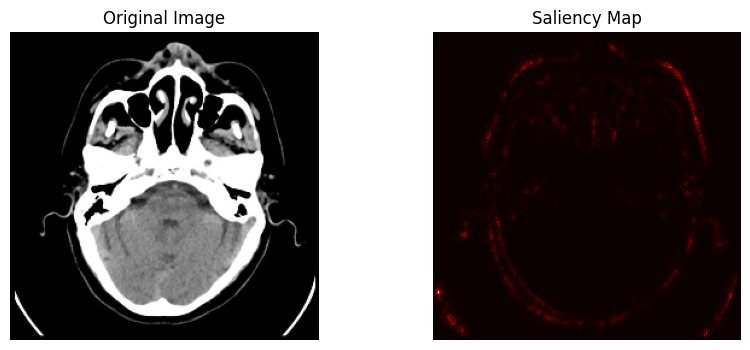

In [135]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def saliency_map(model, image_path, img_width, img_height):
    """
    Generates and displays a saliency map for an image.

    Args:
        model: The Keras model.
        image_path: Path to the image file.
        img_width: Width to resize the image to.
        img_height: Height to resize the image to.
    """

    # Load and preprocess the image with consistent resizing
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    image_tensor = np.expand_dims(img, axis=0) / 255.0
    image_tensor = tf.convert_to_tensor(image_tensor, dtype=tf.float32)
    image_tensor = tf.Variable(image_tensor)

    with tf.GradientTape() as tape:
        predictions = model(image_tensor)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_tensor[0])
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()
model = tf.keras.models.load_model('stroke_model.keras')
img_width, img_height = 256, 256

#Call saliency_map with the image path and resizing parameters
img_path = '/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
saliency_map(model, img_path, img_width, img_height)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Prediction: Stroke


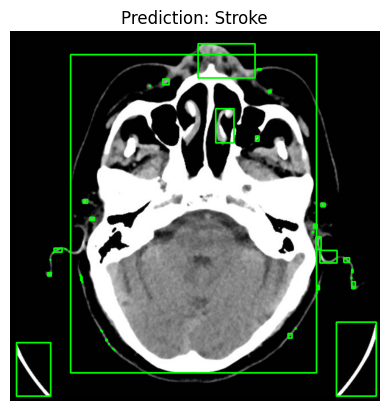

In [136]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#Function to highlight affected area using contours
def Affected_Area(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

# Load model
model = tf.keras.models.load_model('stroke_model.keras')  # use your correct path here

# Consistent image dimensions - This is the key fix
img_width, img_height = 256, 256  # use your model's input size (same as training)

def detect_stroke(image_path):
    """
    Detects stroke in an image and highlights the affected area.

    Args:
        image_path: Path to the image file.

    Returns:
        A tuple containing:
            - Prediction (0 for No Stroke, 1 for Stroke)
            - Original image with affected area highlighted (if Stroke is predicted)
    """
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (img_width, img_height))
    input_img = np.expand_dims(img_resized, axis=0) / 255.0

    # Make prediction
    prediction = model.predict(input_img)[0][0]
    predicted_class_index = int(prediction >= 0.5)

    # Highlight affected area if stroke is detected
    if predicted_class_index == 1:
        highlighted_image = Affected_Area(image_path)
        return predicted_class_index, highlighted_image
    else:
        return predicted_class_index, img
# Example usage
image_path = '/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg'
prediction, result_image = detect_stroke(image_path)

class_names = ['No Stroke', 'Stroke']
print(f"Prediction: {class_names[prediction]}")

plt.imshow(result_image)
plt.title(f"Prediction: {class_names[prediction]}")
plt.axis('off')
plt.show()

INTEGRATED GRADIENT

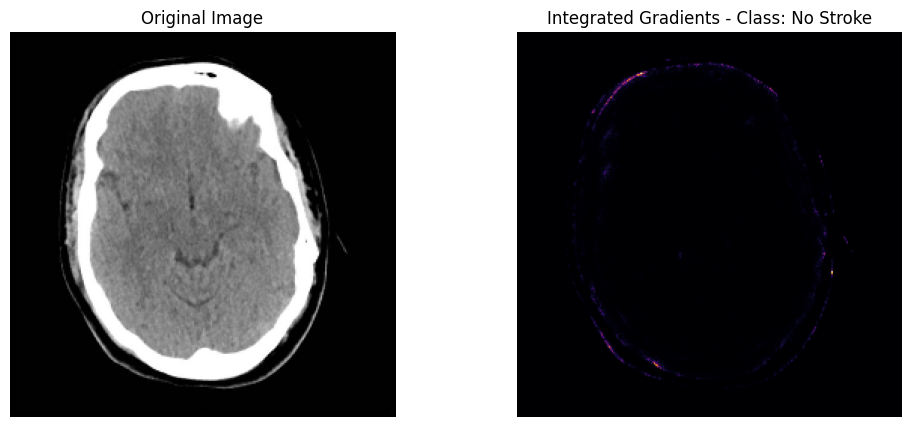

In [138]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    return baseline + alphas_x * (image - baseline)

def compute_gradients(model, images, class_index):
    with tf.GradientTape() as tape:
        tape.watch(images)
        probs = model(images)
        outputs = probs[:, 0]
    return tape.gradient(outputs, images)

def integrated_gradients(model, image, baseline=None, class_index=None, m_steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=image.shape)

    # 1. Generate alphas for interpolation
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # 2. Interpolate between baseline and image
    interpolated_images = interpolate_images(baseline, image, alphas)

    # 3. Compute gradients for interpolated images
    grads = compute_gradients(model, interpolated_images, class_index)

    # 4. Average gradients
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Compute integrated gradients
    integrated_grads = (image - baseline) * avg_grads
    return integrated_grads

model = tf.keras.models.load_model('stroke_model.keras')
img_path = '/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Normal/100 (14).jpg'
img_width, img_height = 256, 256
img = cv2.imread(img_path)
img = cv2.resize(img, (img_width, img_height))
img = img / 255.0
input_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)

preds = model(input_tensor)
class_index = int(preds[0] >= 0.5)
attributions = integrated_gradients(model, input_tensor, class_index=class_index, m_steps=100)
attributions = tf.reduce_sum(tf.math.abs(attributions), axis=-1)[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attributions, cmap='inferno')
plt.title(f'Integrated Gradients - Class: {["No Stroke", "Stroke"][class_index]}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


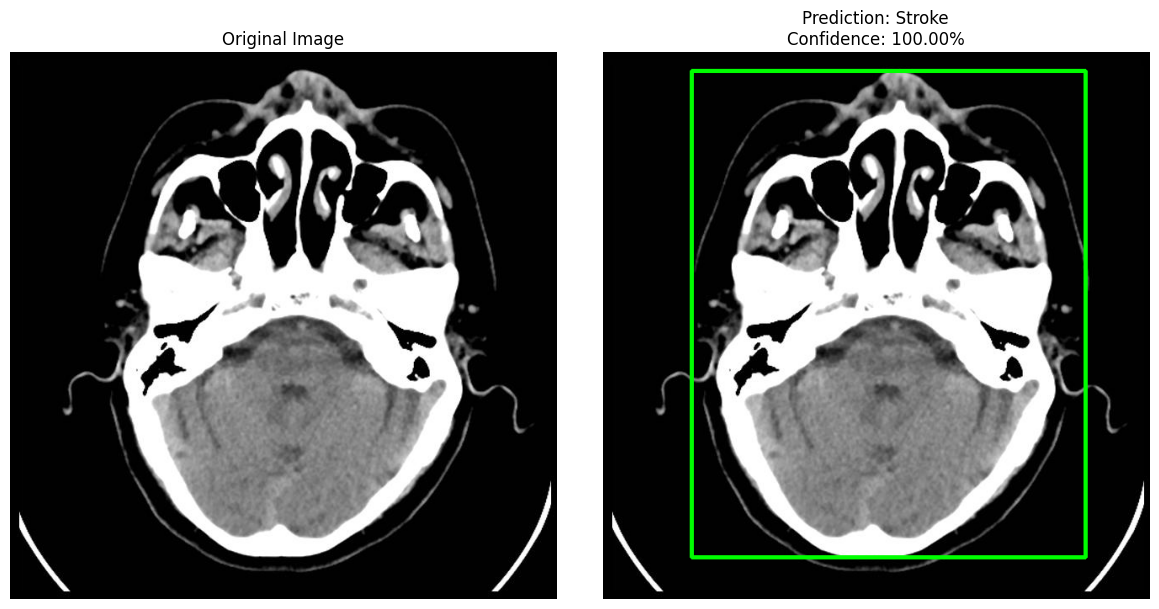

Prediction: Stroke
Confidence: 100.00%


In [139]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
model = tf.keras.models.load_model(
    "/content/brain_stroke_model.keras",
    compile=False
)

dummy = np.zeros((1, 256, 256, 3), dtype=np.float32)
model.predict(dummy)
def Affected_Area(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Better smoothing + threshold
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    _, thresholded_image = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological closing
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes (only for large areas)
    for contour in contours:
        if cv2.contourArea(contour) > 1500:  # remove noise
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
IMG_WIDTH, IMG_HEIGHT = 256, 256
def detect_stroke(image_path):

    # Read & preprocess
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    input_img = np.expand_dims(img_resized, axis=0) / 255.0

    # Predict stroke
    prediction = model.predict(input_img)[0][0]
    predicted_class_index = int(prediction >= 0.5)
    confidence = prediction if predicted_class_index == 1 else (1 - prediction)

    # If stroke detected, highlight area
    if predicted_class_index == 1:
        highlighted_img = Affected_Area(image_path)
        return predicted_class_index, confidence, highlighted_img

    # If normal, return original
    return predicted_class_index, confidence, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_path = "/content/brain_data/Brain_Stroke_CT-SCAN_image/Test/Stroke/58 (12).jpg"

prediction, confidence, result_image = detect_stroke(image_path)

# Load original for comparison
original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

class_names = ["No Stroke", "Stroke"]
label = class_names[prediction]
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result_image)
plt.title(f"Prediction: {label}\nConfidence: {confidence*100:.2f}%")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Prediction: {label}")
print(f"Confidence: {confidence*100:.2f}%")

